# 데이터 전처리

In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from plotnine import *
import plotnine

In [4]:
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes

In [5]:
from tqdm import tqdm_notebook
import time
from ipypb import ipb

In [6]:
# 경고 메세지 안보이게 설정
import warnings
warnings.filterwarnings('ignore')

In [7]:
from scipy.stats import mode

## 분석할 테이블 불러오기

In [8]:
# 영수증 번호가 E인 것들 select + 1번 + 4번 연결
con = sqlite3.connect("database/lpoint.db", isolation_level=None) # lpoint db 생성 or 연결


data = pd.read_sql('''
SELECT P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct
FROM PDDE AS P, DEMO AS D, PD_CLAC AS C
WHERE P.cust = D.cust AND P.pd_c = C.pd_c
GROUP BY P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct;
''', con, index_col=None)

con.close()

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144389 entries, 0 to 4144388
Data columns (total 15 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   cust          object
 1   ma_fem_dv     object
 2   ages          object
 3   zon_hlv       object
 4   rct_no        object
 5   de_dt         int64 
 6   chnl_dv       int64 
 7   cop_c         object
 8   pd_c          object
 9   clac_hlv_nm   object
 10  clac_mcls_nm  object
 11  pd_nm         object
 12  de_hr         int64 
 13  buy_am        int64 
 14  buy_ct        int64 
dtypes: int64(5), object(10)
memory usage: 474.3+ MB


In [23]:
## 불러온 테이블 컬럼명 한글로 재설정
data.columns = ['고객번호', '성별', '연령대', '거주지분류대코드', '영수증번호', '구매일자', '채널구분', '제휴사', 
              '상품코드', '상품대분류명', '상품중분류명', '상품소분류명',
              '구매시간', '구매금액', '구매수량']

## 구매월 변수 추가

In [13]:
data['구매월'] = data['구매일자'].map(lambda x: str(x)[4:6]+'월')

# 고객코드 중복 처리

In [163]:
## 중복처리할 변수 선택
df = data[['고객번호', '성별', '연령대', '거주지분류대코드', '채널구분', '상품대분류명', '구매시간', '구매금액', '구매월']]
df.head()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품대분류명,구매시간,구매금액,구매월
0,M000034966,여성,40대,Z07,1,스포츠패션,18,19000,01월
1,M000034966,여성,40대,Z07,1,스포츠패션,18,59000,01월
2,M000034966,여성,40대,Z07,1,스포츠패션,18,100,01월
3,M000034966,여성,40대,Z07,1,스포츠패션,18,62100,01월
4,M000034966,여성,40대,Z07,1,속옷/양말/홈웨어,13,5000,03월


In [164]:
## 고객번호의 종류 개수
print("고객번호 종류 개수:", len(df2['고객번호'].unique()))

고객번호 종류 개수: 26917


In [165]:
## 중복처리된 데이터 담을 변수 생성
newdf = df.drop_duplicates(['고객번호'], keep='first', ignore_index=True)

In [166]:
# 채널구분 - 평균값
newdf[['고객번호', '채널구분']] = df.groupby('고객번호')['채널구분'].mean().reset_index()
newdf.loc[newdf['채널구분'] <= 1.5, '채널구분'] = 1 # 평균이 1.5라면 오프라인으로 구분(오프라인이 다수이기 때문)
newdf.loc[newdf['채널구분'] > 1.5, '채널구분'] = 2

In [167]:
# 상품대분류명 - 최빈값
newdf[['고객번호', '상품대분류명']] = df.groupby('고객번호')['상품대분류명'].agg(**{'상품대분류명':lambda x:x.mode()[0]}).reset_index()

In [168]:
# 구매시간 - 최빈값
newdf[['고객번호', '구매시간']] = df.groupby('고객번호')['구매시간'].agg(**{'구매시간':lambda x:x.mode()[0]}).reset_index()

In [170]:
# 구매금액 - 평균값
newdf[['고객번호', '구매금액']] = df.groupby('고객번호')['구매금액'].agg(**{'구매금액':lambda x:round(x.mean())}).reset_index()

In [171]:
# 구매월 - 최빈값
newdf[['고객번호', '구매월']] = df.groupby('고객번호')['구매월'].agg(**{'구매월':lambda x:x.mode()[0]}).reset_index()

In [172]:
newdf.head()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품대분류명,구매시간,구매금액,구매월
0,M000034966,여성,40대,Z07,1.0,과자,16,12757,09월
1,M000136117,여성,30대,Z11,1.0,여성의류,16,267864,01월
2,M000201112,여성,50대,Z17,1.0,대용식,15,2571,07월
3,M000225114,여성,40대,Z17,1.0,과자,18,11556,04월
4,M000261625,여성,40대,Z17,1.0,화장품/뷰티케어,18,91648,07월


In [173]:
newdf.tail()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품대분류명,구매시간,구매금액,구매월
26912,M999599111,여성,40대,Z04,1.0,유제품,19,43648,04월
26913,M999673157,남성,30대,Z10,1.0,담배,1,118807,12월
26914,M999770689,여성,30대,Z16,1.0,조리식품,21,3826,02월
26915,M999849895,여성,20대,Z04,1.0,기타(비상품),19,15657,08월
26916,M999962961,여성,50대,Z17,1.0,채소,17,36794,03월


In [138]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26917 entries, 0 to 26916
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   고객번호      26917 non-null  object 
 1   성별        26917 non-null  object 
 2   연령대       26917 non-null  object 
 3   거주지분류대코드  26917 non-null  object 
 4   채널구분      26917 non-null  float64
 5   상품대분류명    26917 non-null  object 
 6   구매시간      26917 non-null  int64  
 7   구매금액      26917 non-null  int64  
 8   구매월       26917 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 1.8+ MB


# 군집화

## 스케일링 X

In [124]:
ndf1 = newdf.drop(['고객번호'], axis=1)

In [125]:
# Categorical 변수 정해주기
catcol = [ndf1.columns.get_loc(col) for col in list(ndf1.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '상품대분류명', '구매월']
Categorical columns position : [0, 1, 2, 4, 7]


In [126]:
dfmatrix1 = ndf1.to_numpy()
dfmatrix1

array([['여성', '40대', 'Z07', ..., 16, 12757, '09월'],
       ['여성', '30대', 'Z11', ..., 16, 267864, '01월'],
       ['여성', '50대', 'Z17', ..., 15, 2571, '07월'],
       ...,
       ['여성', '30대', 'Z16', ..., 21, 3826, '02월'],
       ['여성', '20대', 'Z04', ..., 19, 15657, '08월'],
       ['여성', '50대', 'Z17', ..., 17, 36794, '03월']], dtype=object)

### 군집화

In [127]:
## Kprototypes 군집분석
cost = []
for cluster in ipb(range(1, 7)):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix1, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 6/6 [01:09:57<23:31, 699.46s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 598655820597123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 598655820597123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 598655820597123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 598655820597123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 598655820597123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 598655820597123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 598655820597123.0
Init: initial

Run: 8, iteration: 7/100, moves: 22, ncost: 298863018316171.9
Run: 8, iteration: 8/100, moves: 12, ncost: 298690774119516.2
Run: 8, iteration: 9/100, moves: 12, ncost: 298420218845697.56
Run: 8, iteration: 10/100, moves: 5, ncost: 298375369030554.56
Run: 8, iteration: 11/100, moves: 4, ncost: 298343101329970.1
Run: 8, iteration: 12/100, moves: 2, ncost: 298334742698104.25
Run: 8, iteration: 13/100, moves: 0, ncost: 298334742698104.25
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 535, ncost: 329110219056651.44
Run: 9, iteration: 2/100, moves: 265, ncost: 311424659140884.0
Run: 9, iteration: 3/100, moves: 116, ncost: 303399895557563.1
Run: 9, iteration: 4/100, moves: 64, ncost: 299564457322686.56
Run: 9, iteration: 5/100, moves: 22, ncost: 298863018316171.9
Run: 9, iteration: 6/100, moves: 12, ncost: 298690774119516.2
Run: 9, iteration: 7/100, moves: 12, ncost: 298420218845697.56
Run: 9, iteration: 8/100, moves: 5, ncost:

Run: 6, iteration: 3/100, moves: 1186, ncost: 216179404734095.1
Run: 6, iteration: 4/100, moves: 806, ncost: 191654144610485.53
Run: 6, iteration: 5/100, moves: 507, ncost: 168640490537202.38
Run: 6, iteration: 6/100, moves: 288, ncost: 158619208378316.66
Run: 6, iteration: 7/100, moves: 183, ncost: 154069732889026.22
Run: 6, iteration: 8/100, moves: 111, ncost: 152526424429152.28
Run: 6, iteration: 9/100, moves: 78, ncost: 151852140697989.66
Run: 6, iteration: 10/100, moves: 43, ncost: 151545896829486.88
Run: 6, iteration: 11/100, moves: 27, ncost: 151146307402223.28
Run: 6, iteration: 12/100, moves: 15, ncost: 151017863455267.7
Run: 6, iteration: 13/100, moves: 0, ncost: 151017863455267.7
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 2341, ncost: 271552656694545.56
Run: 7, iteration: 2/100, moves: 1816, ncost: 232191886971818.3
Run: 7, iteration: 3/100, moves: 1

Run: 3, iteration: 11/100, moves: 37, ncost: 98218227044786.03
Run: 3, iteration: 12/100, moves: 32, ncost: 98201057764820.8
Run: 3, iteration: 13/100, moves: 19, ncost: 98197080579266.98
Run: 3, iteration: 14/100, moves: 2, ncost: 98197058475619.12
Run: 3, iteration: 15/100, moves: 0, ncost: 98197058475619.12
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 1250, ncost: 206609091716318.75
Run: 4, iteration: 2/100, moves: 614, ncost: 164397423391838.16
Run: 4, iteration: 3/100, moves: 678, ncost: 126661856823673.81
Run: 4, iteration: 4/100, moves: 721, ncost: 113273324341486.9
Run: 4, iteration: 5/100, moves: 608, ncost: 106621124696266.7
Run: 4, iteration: 6/100, moves: 488, ncost: 102774438330466.

Run: 10, iteration: 2/100, moves: 863, ncost: 185576685818357.84
Run: 10, iteration: 3/100, moves: 1133, ncost: 145690624205810.06
Run: 10, iteration: 4/100, moves: 1104, ncost: 120979714214851.25
Run: 10, iteration: 5/100, moves: 889, ncost: 109648423535165.27
Run: 10, iteration: 6/100, moves: 652, ncost: 104326634084318.89
Run: 10, iteration: 7/100, moves: 491, ncost: 101446913731899.66
Run: 10, iteration: 8/100, moves: 330, ncost: 99924238075276.6
Run: 10, iteration: 9/100, moves: 252, ncost: 98784921005435.25
Run: 10, iteration: 10/100, moves: 176, ncost: 98320653436411.06
Run: 10, iteration: 11/100, moves: 94, ncost: 98246821979064.06
Run: 10, iteration: 12/100, moves: 38, ncost: 98218995228845.55
Run: 10, iteration: 13/100, moves: 34, ncost: 98201057764820.8
Run: 10, iteration: 14/100, moves: 19, ncost: 98197080579266.98
Run: 10, iteration: 15/100, moves: 2, ncost: 98197058475619.12
Run: 10, iteration: 16/100, moves: 0, ncost: 98197058475619.12
Best run was number 1
Cluster initi

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 2178, ncost: 180044041886965.5
Run: 4, iteration: 2/100, moves: 1349, ncost: 122751653810887.62
Run: 4, iteration: 3/100, moves: 633, ncost: 92980006115550.36
Run: 4, iteration: 4/100, moves: 221, ncost: 83694355611692.92
Run: 4, iteration: 5/100, moves: 279, ncost: 79052080087356.92
Run: 4, iteration: 6/100, moves: 330, ncost: 78197946236526.25
Run: 4, iteration: 7/100, moves: 352, ncost: 77675986831657.83
Run: 4, iteration: 8/100, moves: 268, ncost: 77405452236040.36
Run: 4, iteration: 9/100, moves: 223, ncost: 77153984843820.55
Run: 4, iteration: 10/100, moves: 211, ncost: 76875998916202.67
Run: 4, iteration: 11/100, moves: 148, ncost: 76162310146606.62
Run: 4, iteration: 12/100, moves: 147, ncost: 75723

Run: 7, iteration: 19/100, moves: 36, ncost: 75373474447625.39
Run: 7, iteration: 20/100, moves: 37, ncost: 75350802436652.05
Run: 7, iteration: 21/100, moves: 63, ncost: 75328308228637.02
Run: 7, iteration: 22/100, moves: 44, ncost: 75315059489787.6
Run: 7, iteration: 23/100, moves: 37, ncost: 75292054333454.78
Run: 7, iteration: 24/100, moves: 30, ncost: 75288016949523.11
Run: 7, iteration: 25/100, moves: 21, ncost: 75284548519790.19
Run: 7, iteration: 26/100, moves: 21, ncost: 75282549728825.25
Run: 7, iteration: 27/100, moves: 7, ncost: 75282430998280.64
Run: 7, iteration: 28/100, moves: 8, ncost: 75282342232118.34
Run: 7, iteration: 29/100, moves: 4, ncost: 75282306813709.34
Run: 7, iteration: 30/100, moves: 2, ncost: 75282298316936.7
Run: 7, iteration: 31/100, moves: 0, ncost: 75282298316936.7
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing

Cluster initiation: 5
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2729, ncost: 222998226717663.06
Run: 1, iteration: 2/100, moves: 1810, ncost: 172838412575357.56
Run: 1, iteration: 3/100, moves: 1164, ncost: 124629864831169.17
Run: 1, iteration: 4/100, moves: 953, ncost: 96340764835126.64
Run: 1, iteration: 5/100, moves: 1124, ncost: 82323961761465.88
Run: 1, iteration: 6/100, moves: 1200, ncost: 74475479167704.94
Run: 1, iteration: 7/100, moves: 1036, ncost: 71763006749347.62
Run: 1, iteration: 8/100, moves: 929, ncost: 70065688812462.84
Run: 1, iteration: 9/100, moves: 853, ncost: 68644408101127.62
Run: 1, iteration: 10/100, moves: 795, ncost: 66602319653407.19
Run: 1, iteration: 11/100, moves: 671, ncost: 65461976000966.13
Run: 1, iteration: 12/100, moves: 554, ncost: 64777999974514.92
Run: 1, iteration: 13/100, moves: 433, ncost: 64142956187123.08
Run: 1, iteration: 14/100, moves: 416, ncost: 63073815236568.16
Ru

Run: 3, iteration: 22/100, moves: 125, ncost: 45049827180638.24
Run: 3, iteration: 23/100, moves: 107, ncost: 44253812549858.336
Run: 3, iteration: 24/100, moves: 87, ncost: 44173297646918.52
Run: 3, iteration: 25/100, moves: 86, ncost: 44009895699802.24
Run: 3, iteration: 26/100, moves: 84, ncost: 43728086032564.77
Run: 3, iteration: 27/100, moves: 93, ncost: 43676841938739.8
Run: 3, iteration: 28/100, moves: 88, ncost: 43642989941469.83
Run: 3, iteration: 29/100, moves: 59, ncost: 43582805116873.77
Run: 3, iteration: 30/100, moves: 51, ncost: 43569017691444.91
Run: 3, iteration: 31/100, moves: 49, ncost: 43554234581283.625
Run: 3, iteration: 32/100, moves: 49, ncost: 43540960117767.625
Run: 3, iteration: 33/100, moves: 27, ncost: 43538270969031.45
Run: 3, iteration: 34/100, moves: 23, ncost: 43526935565940.33
Run: 3, iteration: 35/100, moves: 21, ncost: 43522177813423.53
Run: 3, iteration: 36/100, moves: 27, ncost: 43518708122479.19
Run: 3, iteration: 37/100, moves: 9, ncost: 4351839

Run: 6, iteration: 11/100, moves: 560, ncost: 64926601409168.06
Run: 6, iteration: 12/100, moves: 485, ncost: 64280147101569.16
Run: 6, iteration: 13/100, moves: 431, ncost: 63231328041031.77
Run: 6, iteration: 14/100, moves: 437, ncost: 62035555819412.84
Run: 6, iteration: 15/100, moves: 403, ncost: 61112159458542.27
Run: 6, iteration: 16/100, moves: 282, ncost: 60506704475596.56
Run: 6, iteration: 17/100, moves: 173, ncost: 60224898924872.586
Run: 6, iteration: 18/100, moves: 117, ncost: 59421859883858.664
Run: 6, iteration: 19/100, moves: 99, ncost: 58265305878506.266
Run: 6, iteration: 20/100, moves: 141, ncost: 57678146139322.55
Run: 6, iteration: 21/100, moves: 170, ncost: 52878643410683.54
Run: 6, iteration: 22/100, moves: 158, ncost: 47693758068502.4
Run: 6, iteration: 23/100, moves: 142, ncost: 46139964611112.01
Run: 6, iteration: 24/100, moves: 145, ncost: 45176027005423.66
Run: 6, iteration: 25/100, moves: 133, ncost: 45003396376414.05
Run: 6, iteration: 26/100, moves: 97, n

Run: 8, iteration: 41/100, moves: 13, ncost: 43518099024352.81
Run: 8, iteration: 42/100, moves: 7, ncost: 43516607625817.68
Run: 8, iteration: 43/100, moves: 4, ncost: 43516556128755.6
Run: 8, iteration: 44/100, moves: 0, ncost: 43516556128755.6
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 12533, ncost: 244803124061208.56
Run: 9, iteration: 2/100, moves: 2982, ncost: 182190956472650.62
Run: 9, iteration: 3/100, moves: 1411, ncost: 134632109618990.94
Run: 9, iteration: 4/100, moves: 1399, ncost: 101298800004604.25
Run: 9, iteration: 5/100, moves: 1442, ncost: 84289683925706.67
Run: 9

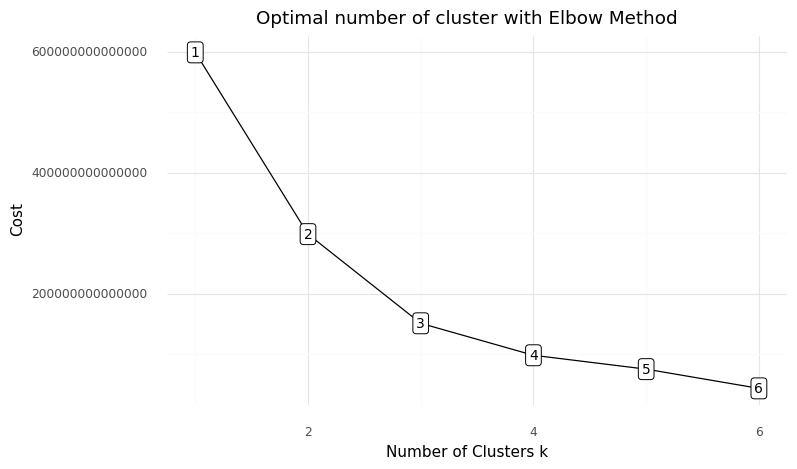

<ggplot: (162508062666)>

In [129]:
## 군집분석 결과 시각화
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

cost가 너무 커서 모델에 문제가 있음을 알 수 있다.

In [130]:
df_cost

,Cluster,Cost
0,1,5.986558e+14
1,2,2.983347e+14
2,3,1.510179e+14
3,4,9.819706e+13
4,5,7.528230e+13
5,6,4.351656e+13


In [140]:
## 성능 평가
from sklearn.metrics import silhouette_score

# Silhouette coefficient
print(silhouette_score(newdf['채널구분'].to_numpy().reshape(-1, 1), kprototype.labels_, metric='euclidean'))
print(silhouette_score(newdf['구매금액'].to_numpy().reshape(-1, 1), kprototype.labels_, metric='euclidean'))
print(silhouette_score(newdf['구매시간'].to_numpy().reshape(-1, 1), kprototype.labels_, metric='euclidean'))

-0.9269971013031411
0.7810439996558101
-0.23185199894986297


범주형 변수 + 수치형 변수에 대해 군집하는 Kprototypes는 성능 평가 하기에 적합하지 않다.

## 스케일링 O

In [201]:
ndf2 = newdf.drop(['고객번호'], axis=1)

In [202]:
ndf2

,성별,연령대,거주지분류대코드,채널구분,상품대분류명,구매시간,구매금액,구매월
0,여성,40대,Z07,1.0,과자,16,12757,09월
1,여성,30대,Z11,1.0,여성의류,16,267864,01월
2,여성,50대,Z17,1.0,대용식,15,2571,07월
3,여성,40대,Z17,1.0,과자,18,11556,04월
4,여성,40대,Z17,1.0,화장품/뷰티케어,18,91648,07월
...,...,...,...,...,...,...,...,...
26912,여성,40대,Z04,1.0,유제품,19,43648,04월
26913,남성,30대,Z10,1.0,담배,1,118807,12월
26914,여성,30대,Z16,1.0,조리식품,21,3826,02월
26915,여성,20대,Z04,1.0,기타(비상품),19,15657,08월


In [203]:
# Categorical 변수 정해주기
catcol = [ndf2.columns.get_loc(col) for col in list(ndf2.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf2.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '상품대분류명', '구매월']
Categorical columns position : [0, 1, 2, 4, 7]


In [205]:
# Scaling
scaler = MinMaxScaler() 
scaler_fit = scaler.fit(ndf2[['채널구분', '구매시간', '구매금액']]) ## 각 칼럼 데이터마다 변환할 함수 생성
ndf2[['채널구분', '구매시간', '구매금액']] = scaler_fit.transform(ndf2[['채널구분', '구매시간', '구매금액']])

In [206]:
dfmatrix2 = ndf2.to_numpy()
dfmatrix2

array([['여성', '40대', 'Z07', ..., 0.6956521739130435,
        0.0016603082517854142, '09월'],
       ['여성', '30대', 'Z11', ..., 0.6956521739130435,
        0.034888225188179994, '01월'],
       ['여성', '50대', 'Z17', ..., 0.6521739130434783,
        0.0003335725608239151, '07월'],
       ...,
       ['여성', '30대', 'Z16', ..., 0.9130434782608695,
        0.0004970374432268879, '02월'],
       ['여성', '20대', 'Z04', ..., 0.8260869565217391,
        0.002038035868493479, '08월'],
       ['여성', '50대', 'Z17', ..., 0.7391304347826086,
        0.004791149190686019, '03월']], dtype=object)

### 군집화

In [146]:
## Kprototypes 군집분석
cost = []
for cluster in ipb(range(1, 7)):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix2, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 6/6 [13:53<02:45, 138.83s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 18690.79436645177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 18690.79436645177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 18690.79436645177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 18690.79436645177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 18690.79436645177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 18690.79436645177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 18690.79436645177
Init: initial

Starting iterations...
Run: 2, iteration: 1/100, moves: 4369, ncost: 14531.768268620799
Run: 2, iteration: 2/100, moves: 148, ncost: 14531.756624295245
Run: 2, iteration: 3/100, moves: 0, ncost: 14531.756624295245
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 7991, ncost: 15031.169525958547
Run: 3, iteration: 2/100, moves: 2331, ncost: 14405.131758737698
Run: 3, iteration: 3/100, moves: 82, ncost: 14402.149895221983
Run: 3, iteration: 4/100, moves: 0, ncost: 14402.149895221983
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 9052, ncost: 15732.158134468888
Run: 4, iteration: 2/100, moves: 1938, ncost: 15719.566771860387
Run: 4, iteration: 3/100, moves: 515, ncost: 15717.142228690038
Run: 4, iteration: 4/100, moves: 125, ncost: 15716.80181181602
Run: 4, iteration: 5/100, moves: 418, ncost: 15716.647040433023
Run: 4, iteration: 6/100, moves: 198, ncost: 15716

Run: 5, iteration: 2/100, moves: 2018, ncost: 13660.403890677642
Run: 5, iteration: 3/100, moves: 64, ncost: 13660.399484410516
Run: 5, iteration: 4/100, moves: 0, ncost: 13660.399484410516
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 7386, ncost: 13276.850414908016
Run: 6, iteration: 2/100, moves: 3038, ncost: 13180.702031718773
Run: 6, iteration: 3/100, moves: 841, ncost: 13179.216514939722
Run: 6, iteration: 4/100, moves: 2, ncost: 13179.215729702602
Run: 6, iteration: 5/100, moves: 0, ncost: 13179.215729702602
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 10554, ncost: 13745.449397492554
Run: 7, iteration: 2/100, moves: 335, ncost: 13723.89998033801
Run: 7, iteration: 3/100, moves: 0, ncost: 13723.89998033801
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 9197, ncost: 13676.6834929756

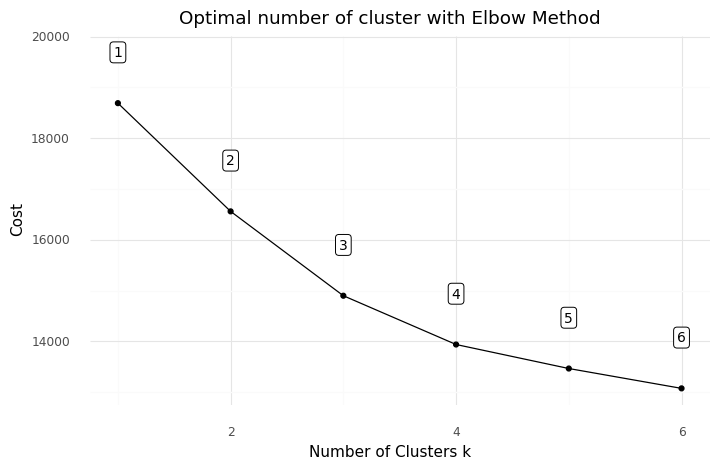

<ggplot: (162492587111)>

In [147]:
## 군집분석 결과 시각화
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [148]:
df_cost

,Cluster,Cost
0,1,18690.794366
1,2,16560.070749
2,3,14899.395494
3,4,13938.817665
4,5,13466.098665
5,6,13075.262555


꺾이는 부분 4를 클러스터 개수로 한다.

In [152]:
## 군집 개수 선택 후 모델 적합하기
# n_clusters = 4으로 한다
kprototype = KPrototypes(n_clusters = 4, init = 'Huang',
                                 random_state = 0, verbose = True)
kprototype.fit_predict(dfmatrix2, categorical = catcol)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7335, ncost: 15173.070662649314
Run: 1, iteration: 2/100, moves: 2309, ncost: 14393.585198875204
Run: 1, iteration: 3/100, moves: 2268, ncost: 14179.881371858037
Run: 1, iteration: 4/100, moves: 595, ncost: 14179.835619134614
Run: 1, iteration: 5/100, moves: 0, ncost: 14179.835619134614
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 4369, ncost: 14531.768268620799
Run: 2, iteration: 2/100, moves: 148, ncost: 14531.756624295245
Run: 2, iteration: 3/100, moves: 0, ncost: 14531.756624295245
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 7991, ncost: 15031.169525958547
Run: 3, iteration: 2/100, moves: 2331, ncost: 14405.131758737698
Run: 3, iteration: 3/100, moves: 82, ncost: 14402.149895221983
Run: 3, iteration: 4/100, moves: 0, ncost: 14402.149895

array([1, 3, 0, ..., 3, 3, 0], dtype=uint16)

In [212]:
# 기존 데이터 프레임에 분류된 군집 추가
ndf2['군집'] = kprototype.labels_ # 군집화에 사용된 컬럼 들어있는 데이터프레임에 군집 추가

In [234]:
# 역정규화
ndf2[['채널구분', '구매시간', '구매금액']] = scaler.inverse_transform(ndf2[['채널구분', '구매시간', '구매금액']])
ndf2[['채널구분', '구매시간', '구매금액']] = ndf2[['채널구분', '구매시간', '구매금액']].astype('int')

In [276]:
# 군집분석 결과 포함한 데이터 저장
ndf2.to_csv("data/modeling_data.csv", index=False, encoding="utf-8-sig")

# 군집분석 결과 분석

In [237]:
ndf2 = pd.read_csv('data/modeling_data.csv', encoding='utf-8')
ndf2.head()

,성별,연령대,거주지분류대코드,채널구분,상품대분류명,구매시간,구매금액,구매월,군집
0,여성,40대,Z07,1,과자,16,12757,09월,1
1,여성,30대,Z11,1,여성의류,16,267864,01월,3
2,여성,50대,Z17,1,대용식,15,2571,07월,0
3,여성,40대,Z17,1,과자,18,11556,04월,0
4,여성,40대,Z17,1,화장품/뷰티케어,18,91648,07월,0


In [240]:
ndf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26917 entries, 0 to 26916
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   성별        26917 non-null  object
 1   연령대       26917 non-null  object
 2   거주지분류대코드  26917 non-null  object
 3   채널구분      26917 non-null  int64 
 4   상품대분류명    26917 non-null  object
 5   구매시간      26917 non-null  int64 
 6   구매금액      26917 non-null  int64 
 7   구매월       26917 non-null  object
 8   군집        26917 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.8+ MB


In [241]:
## 카테고리컬 변수들의 최빈값 확인
ndf2[['성별', '연령대', '거주지분류대코드', '채널구분', '상품대분류명', '구매시간', '구매금액', '구매월', '군집']].groupby('군집').agg([pd.Series.mode]).T

,군집,0,1,2,3
성별,mode,여성,남성,여성,여성
연령대,mode,40대,40대,40대,30대
거주지분류대코드,mode,Z17,Z10,Z17,Z10
채널구분,mode,1,1,2,1
상품대분류명,mode,채소,과자,채소,과자
구매시간,mode,15,16,10,18
구매금액,mode,39900,10000,"[39900, 50000]","[9900, 14999, 69000, 109000]"
구매월,mode,01월,03월,01월,07월


## 시각화

In [217]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [242]:
## 군집 나누기
cluster_0 = ndf2[ndf2['군집'] == 0]
cluster_1 = ndf2[ndf2['군집'] == 1]
cluster_2 = ndf2[ndf2['군집'] == 2]
cluster_3 = ndf2[ndf2['군집'] == 3]

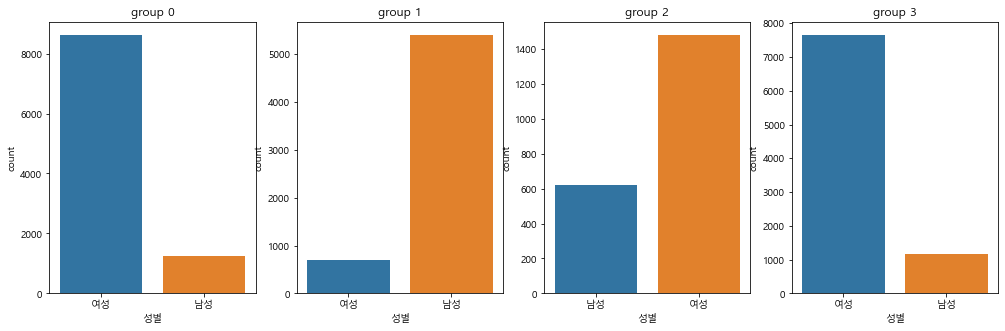

In [219]:
# 성별
plt.figure(figsize=(17,5))
plt.subplot(1,4,1)
a=sns.countplot(x='성별', data=cluster_0)
a.set(title = "group 0")
plt.subplot(1,4,2)
b=sns.countplot(x='성별', data=cluster_1)
b.set(title = "group 1")
plt.subplot(1,4,3)
c=sns.countplot(x='성별', data=cluster_2)
c.set(title = "group 2")
plt.subplot(1,4,4)
d=sns.countplot(x='성별', data=cluster_3)
d.set(title = "group 3")
plt.show()

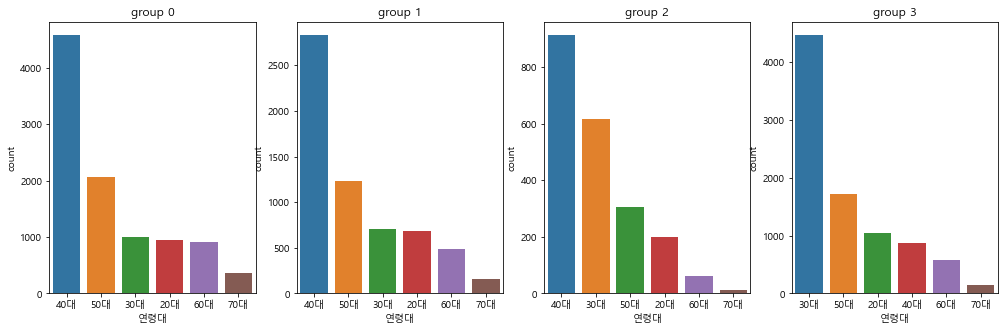

In [220]:
# 연령대
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.countplot(x='연령대', data=cluster_0, order = cluster_0['연령대'].value_counts().index)
a.set(title = "group 0")
plt.subplot(142)
b=sns.countplot(x='연령대', data=cluster_1, order = cluster_1['연령대'].value_counts().index)
b.set(title = "group 1")
plt.subplot(143)
c=sns.countplot(x='연령대', data=cluster_2, order = cluster_2['연령대'].value_counts().index)
c.set(title = "group 2")
plt.subplot(144)
d=sns.countplot(x='연령대', data=cluster_3, order = cluster_3['연령대'].value_counts().index)
d.set(title = "group 3")
plt.show()

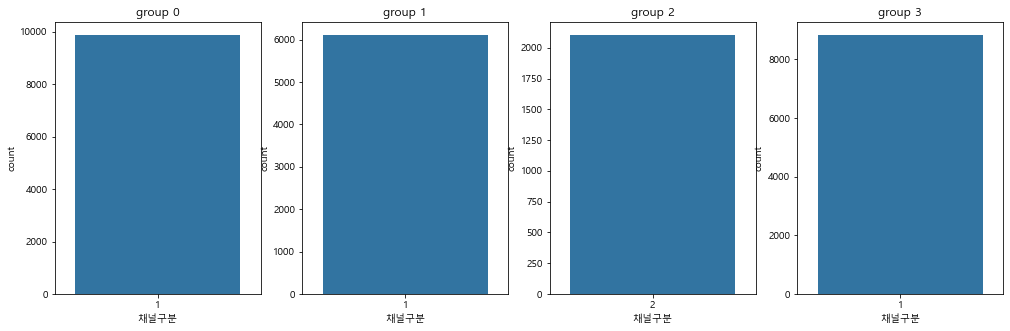

In [243]:
# 채널구분
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.countplot(x='채널구분', data=cluster_0, order = cluster_0['채널구분'].value_counts().index)
a.set(title = "group 0")
plt.subplot(142)
b=sns.countplot(x='채널구분', data=cluster_1, order = cluster_1['채널구분'].value_counts().index)
b.set(title = "group 1")
plt.subplot(143)
c=sns.countplot(x='채널구분', data=cluster_2, order = cluster_2['채널구분'].value_counts().index)
c.set(title = "group 2")
plt.subplot(144)
d=sns.countplot(x='채널구분', data=cluster_3, order = cluster_3['채널구분'].value_counts().index)
d.set(title = "group 3")
plt.show()

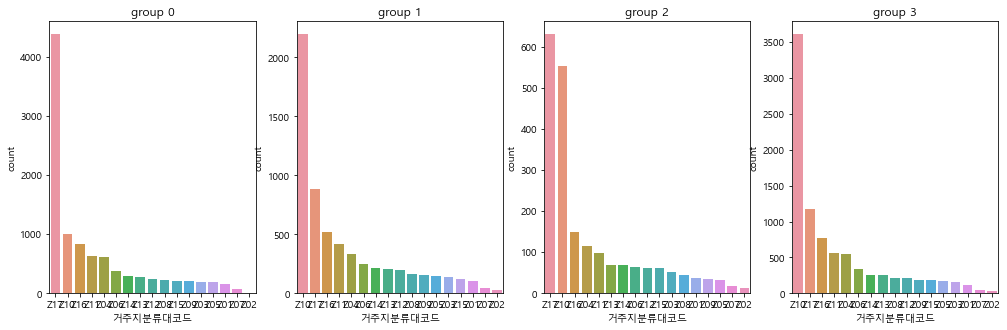

In [222]:
# 거주지분류대코드
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.countplot(x='거주지분류대코드', data=cluster_0, order = cluster_0['거주지분류대코드'].value_counts().index)
a.set(title = "group 0")
plt.subplot(142)
b=sns.countplot(x='거주지분류대코드', data=cluster_1, order = cluster_1['거주지분류대코드'].value_counts().index)
b.set(title = "group 1")
plt.subplot(143)
c=sns.countplot(x='거주지분류대코드', data=cluster_2, order = cluster_2['거주지분류대코드'].value_counts().index)
c.set(title = "group 2")
plt.subplot(144)
c=sns.countplot(x='거주지분류대코드', data=cluster_3, order = cluster_3['거주지분류대코드'].value_counts().index)
c.set(title = "group 3")
plt.show()

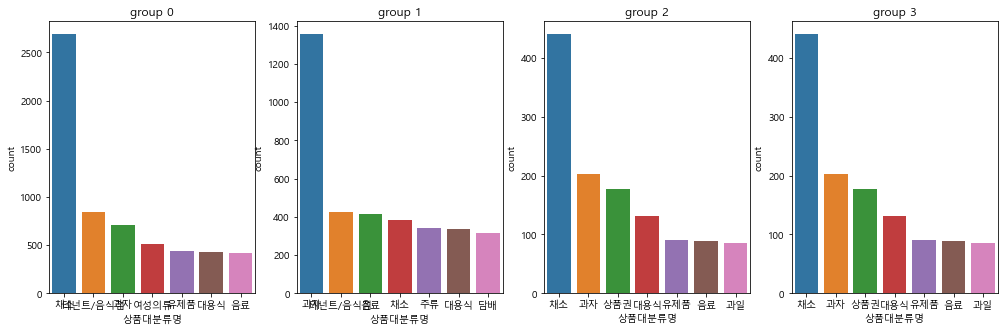

In [223]:
# 상품대분류명
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.countplot(x='상품대분류명', data=cluster_0, order = cluster_0['상품대분류명'].value_counts().index[:7])
a.set(title = "group 0")
plt.subplot(142)
b=sns.countplot(x='상품대분류명', data=cluster_1, order = cluster_1['상품대분류명'].value_counts().index[:7])
b.set(title = "group 1")
plt.subplot(143)
c=sns.countplot(x='상품대분류명', data=cluster_2, order = cluster_2['상품대분류명'].value_counts().index[:7])
c.set(title = "group 2")
plt.subplot(144)
d=sns.countplot(x='상품대분류명', data=cluster_2, order = cluster_2['상품대분류명'].value_counts().index[:7])
d.set(title = "group 3")
plt.show()

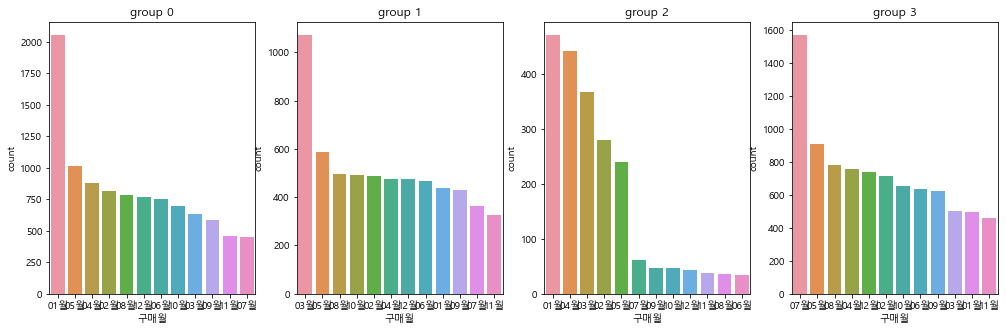

In [224]:
# 구매월
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.countplot(x='구매월', data=cluster_0, order = cluster_0['구매월'].value_counts().index)
a.set(title = "group 0")
plt.subplot(142)
b=sns.countplot(x='구매월', data=cluster_1, order = cluster_1['구매월'].value_counts().index)
b.set(title = "group 1")
plt.subplot(143)
c=sns.countplot(x='구매월', data=cluster_2, order = cluster_2['구매월'].value_counts().index)
c.set(title = "group 2")
plt.subplot(144)
d=sns.countplot(x='구매월', data=cluster_3, order = cluster_3['구매월'].value_counts().index)
d.set(title = "group 3")
plt.show()

수치형 변수 확인해보기

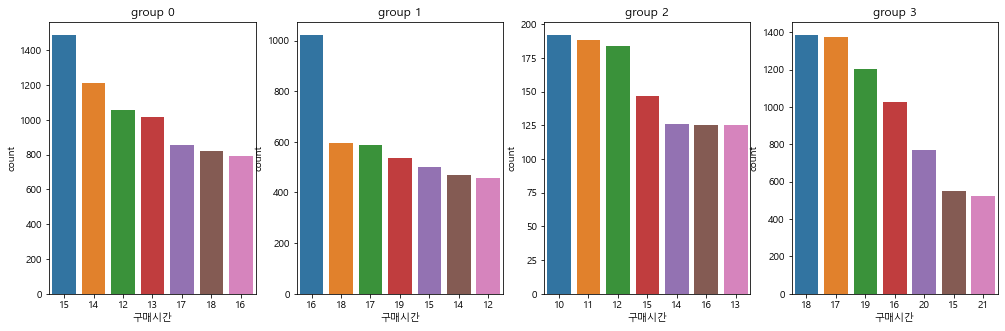

In [244]:
# 구매시간
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.countplot(x='구매시간', data=cluster_0, order = cluster_0['구매시간'].value_counts().index[:7])
a.set(title = "group 0")
plt.subplot(142)
b=sns.countplot(x='구매시간', data=cluster_1, order = cluster_1['구매시간'].value_counts().index[:7])
b.set(title = "group 1")
plt.subplot(143)
c=sns.countplot(x='구매시간', data=cluster_2, order = cluster_2['구매시간'].value_counts().index[:7])
c.set(title = "group 2")
plt.subplot(144)
d=sns.countplot(x='구매시간', data=cluster_3, order = cluster_3['구매시간'].value_counts().index[:7])
d.set(title = "group 3")
plt.show()

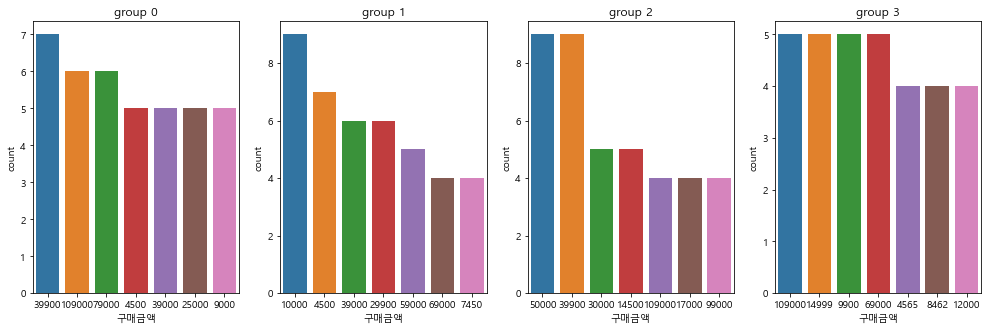

In [245]:
# 구매금액
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.countplot(x='구매금액', data=cluster_0, order = cluster_0['구매금액'].value_counts().index[:7])
a.set(title = "group 0")
plt.subplot(142)
b=sns.countplot(x='구매금액', data=cluster_1, order = cluster_1['구매금액'].value_counts().index[:7])
b.set(title = "group 1")
plt.subplot(143)
c=sns.countplot(x='구매금액', data=cluster_2, order = cluster_2['구매금액'].value_counts().index[:7])
c.set(title = "group 2")
plt.subplot(144)
d=sns.countplot(x='구매금액', data=cluster_3, order = cluster_3['구매금액'].value_counts().index[:7])
d.set(title = "group 3")
plt.show()

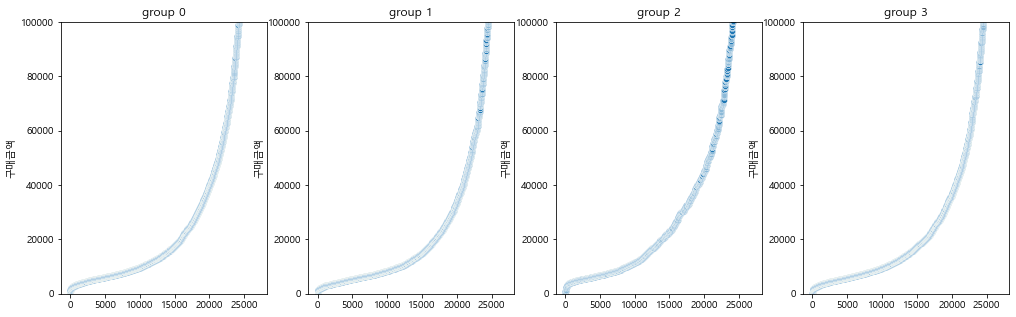

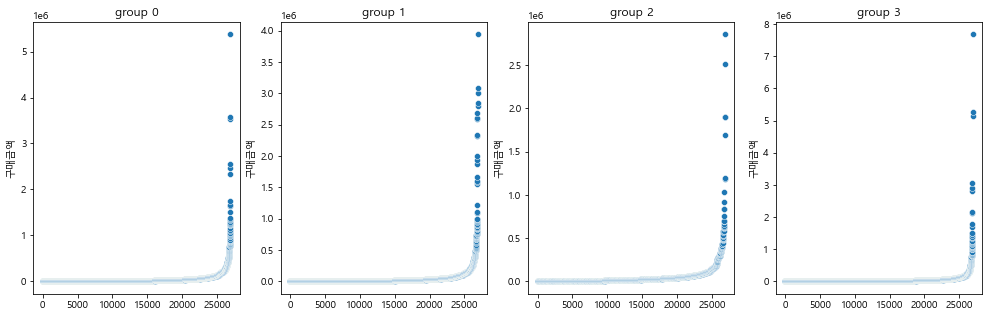

In [275]:
plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.scatterplot(x=cluster_0.index, y=cluster_0['구매금액'].sort_values())
a.set(title = "group 0")
a.set(ylim=(0, 100000))
plt.subplot(142)
b=sns.scatterplot(x=cluster_1.index, y=cluster_1['구매금액'].sort_values())
b.set(title = "group 1")
b.set(ylim=(0, 100000))
plt.subplot(143)
c=sns.scatterplot(x=cluster_2.index, y=cluster_2['구매금액'].sort_values())
c.set(title = "group 2")
c.set(ylim=(0, 100000))
plt.subplot(144)
d=sns.scatterplot(x=cluster_3.index, y=cluster_3['구매금액'].sort_values())
d.set(title = "group 3")
d.set(ylim=(0, 100000))
plt.show()

plt.figure(figsize=(17,5))
plt.subplot(141)
a=sns.scatterplot(x=cluster_0.index, y=cluster_0['구매금액'].sort_values())
a.set(title = "group 0")
plt.subplot(142)
b=sns.scatterplot(x=cluster_1.index, y=cluster_1['구매금액'].sort_values())
b.set(title = "group 1")
plt.subplot(143)
c=sns.scatterplot(x=cluster_2.index, y=cluster_2['구매금액'].sort_values())
c.set(title = "group 2")
plt.subplot(144)
d=sns.scatterplot(x=cluster_3.index, y=cluster_3['구매금액'].sort_values())
d.set(title = "group 3")
plt.show()